In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

from sklearn.model_selection import train_test_split
import os
import pickle
import random
import numpy as np
import itertools

Using TensorFlow backend.


# Captcha solver
## Stage 2 Variant

For this experiment, we will build stage 2 of the captcha solver. This stage takes in an image that has been classified previously by the stage 1 classifier (telling the stage 2 that there are n characters). Assuming that the stage 1 classifier is mostly correct (0.98 acc), we will build a specialised classifier for each $n$ captcha length.

i.e. If we wish to classify captchas of length 3 to 7, will need to build 5 separate classifiers.

In [2]:
DATA_DIR = 'data_npy'
DATA_RAW_DIR = 'data'
MODEL_NAME = 'char_stage2_exp01.h5'
batch_size = 32

width = 150
height = 60 #Uniform squashing of images

# This parameter determines the captcha len to use
CAPTCHA_LEN = 7
MODEL_NAME = str(CAPTCHA_LEN) + MODEL_NAME

char_set = ('_0123456789'
            'abcdefghijklmnopqrstuvwxyz'
            'ABCDEFGHIJKLMNOPQRSTUVWXYZ')
char_map = {char:idx for idx, char in enumerate(char_set)}
num_classes = len(char_set)

In [3]:
#Load training data
file_names = [os.path.join(DATA_DIR, str(CAPTCHA_LEN) + f) for f in ['train_X.npy', 'train_y.npy', 'val_X.npy', 'val_y.npy']]
#Check if cache already exists
if not all(os.path.exists(f) for f in file_names):
    print("No previous cache exists for %d chars. Building..."%CAPTCHA_LEN)
    from utils_dump_to_npy import main as convert_path_to_npy
    convert_path_to_npy(IMAGE_PATH=os.path.join('data', str(CAPTCHA_LEN)),
                       OUTPUT_PATH=DATA_DIR,
                       OUTPUT_NAME=str(CAPTCHA_LEN)+'train')
    convert_path_to_npy(IMAGE_PATH=os.path.join('data_val', str(CAPTCHA_LEN)),
                       OUTPUT_PATH=DATA_DIR,
                       OUTPUT_NAME=str(CAPTCHA_LEN)+'val') 
    
    

In [4]:
train_X = np.load(os.path.join(DATA_DIR, str(CAPTCHA_LEN) + 'train_X.npy'))
train_Y = np.load(os.path.join(DATA_DIR, str(CAPTCHA_LEN) + 'train_y.npy'))

val_X = np.load(os.path.join(DATA_DIR, str(CAPTCHA_LEN) + 'val_X.npy'))
val_Y = np.load(os.path.join(DATA_DIR, str(CAPTCHA_LEN) + 'val_y.npy'))

print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)

(230101, 60, 150, 3) (230101, 7)
(29901, 60, 150, 3) (29901, 7)


In [5]:
#Helper function to reverse encoding
def array_to_string(y):
    s = ''.join(char_set[i] for i in y).rstrip('_')
    return s

In [6]:
# train_X = train_X.astype(np.float32) / 255
# val_X = val_X.astype(np.float32) / 255

UbhDuA6


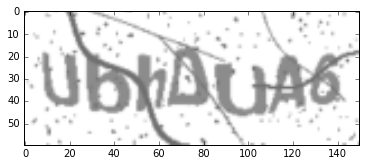

In [7]:
selected = np.random.randint(0, len(train_X))
print(array_to_string(train_Y[selected]))
plt.imshow(train_X[selected])
plt.show()

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255,
                               shear_range=0.05,
                               channel_shift_range=0.2,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               fill_mode='reflect'
                              )

val_datagen = ImageDataGenerator(rescale=1/255)

In [9]:
# train_generator = train_datagen.flow(train_X, train_Y, batch_size=batch_size, shuffle=True)
# val_generator = val_datagen.flow(val_X, val_Y, batch_size=batch_size, shuffle=False)

In [10]:
def mixed_block(x, num_filt, block_num):
    branch1x1 = Conv2D(num_filt, (1,1), activation='relu', padding='same', name='block%d_1x1_c1'%block_num)(x)
    branch1x1 = BatchNormalization(name='block%d_1x1_bn1'%block_num)(branch1x1)
    
    branch3x3 = Conv2D(int(num_filt*0.75), (1,1), activation='relu', padding='same', name='block%d_3x3_c1'%block_num)(x)
    branch3x3 = BatchNormalization( name='block%d_3x3_bn1'%block_num)(branch3x3)
    branch3x3 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_3x3_c2'%block_num)(branch3x3)
    branch3x3 = BatchNormalization( name='block%d_3x3_bn2'%block_num)(branch3x3)
    
    branch5x5 = Conv2D(int(num_filt*0.75), (1,1), activation='relu', padding='same', name='block%d_5x5_c1'%block_num)(x)
    branch5x5 = BatchNormalization(name='block%d_5x5_bn1'%block_num)(branch5x5)
    branch5x5 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_5x5_c2'%block_num)(branch5x5)
    branch5x5 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_5x5_c3'%block_num)(branch5x5)
    branch5x5 = BatchNormalization(name='block%d_5x5_bn2'%block_num)(branch5x5)    
    
    #branch5x5 = Conv2D(num_filt, (5,5), activation='relu', padding='same', name='block%d_5x5_c2'%block_num)(branch5x5)
    #branch5x5 = BatchNormalization(name='block%d_5x5_bn2'%block_num)(branch5x5)
    
    branch_pool = AveragePooling2D((3,3), strides=(1,1), padding='same', name='block%d_pool_pool1'%block_num)(x)
    branch_pool = Conv2D(int(num_filt//2), (1,1), activation='relu', name='block%d_pool_c1'%block_num)(branch_pool)
    
    out = Concatenate(name='mixed_%d'%block_num, axis=3)([branch1x1, branch3x3, branch5x5, branch_pool])
    return out

In [11]:
inputs = Input(shape=(height, width, 3))
x = Conv2D(32, (3,3), activation='relu', name='conv1_c1')(inputs)
x = BatchNormalization(name='conv1_bn1')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv1_c2')(x)
x = BatchNormalization(name='conv1_bn2')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv1_pool1')(x)

x = Conv2D(128, (3,3), activation='relu', name='conv2_c1')(x)
x = BatchNormalization(name='conv2_bn1')(x)
x = Conv2D(192, (3,3), activation='relu', name='conv2_c2')(x)
x = BatchNormalization(name='conv2_bn2')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv2_pool1')(x)
x = Dropout(0.1)(x)

#x = Conv2D(256, (3,3), activation='relu', name='conv3_c1')(x)
x = mixed_block(x, 64, 0)
#x = BatchNormalization(name='conv3_bn1')(x)
x = mixed_block(x, 96, 1)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv3_pool1')(x)
x = Dropout(0.2)(x)

x = mixed_block(x, 124, 2)
x = Dropout(0.4)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

loss_list = []
output_names = ['output' + str(i) for i in range(CAPTCHA_LEN)]
for output in output_names:
    dense_output = Dense(num_classes, activation='softmax', name=output)(x)
    loss_list.append(dense_output)

model = Model(inputs=inputs, outputs=loss_list)

opt = keras.optimizers.adam(decay=1e-6)
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy",)
#               loss_weights={
#                  'output0': 0.025,
#                  'output1': 0.025,
#                  'output2': 0.2,
#                  'output3': 0.5,
#                  'output4': 0.2,
#                  'output5': 0.025,
#                  'output6': 0.025
#               }),
              #metric={output:['accuracy'] for output in output_names})

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 60, 150, 3)    0                                            
____________________________________________________________________________________________________
conv1_c1 (Conv2D)                (None, 58, 148, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv1_bn1 (BatchNormalization)   (None, 58, 148, 32)   128         conv1_c1[0][0]                   
____________________________________________________________________________________________________
conv1_c2 (Conv2D)                (None, 58, 148, 64)   18496       conv1_bn1[0][0]                  
___________________________________________________________________________________________

In [12]:
def createGenerator(X, Y, datagen, batch_size=32, shuffle=True):
    batches = datagen.flow(X, Y, batch_size=batch_size, shuffle=shuffle)
    
    while True:
        x, y = batches.next()
        yield x, {name:y[:,idx] for idx, name in enumerate(output_names)}
        
def custom_accuracy(y_true, y_pred):
    correct = y_true == y_pred
    correct = np.min(correct, axis=1)
    return np.sum(correct) / len(correct)

In [13]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
#               patience=3, min_lr=0.00001)
# model_chkpt = ModelCheckpoint(filepath=MODEL_NAME, monitor='val_loss', verbose=1, save_best_only=True)

epochs = 100
batch_size = 32


# hist = model.fit_generator(createGenerator(train_X, train_Y, train_datagen, batch_size=32),
#                     steps_per_epoch=len(train_X)//batch_size,
#                     epochs=epochs,
#                     validation_data=createGenerator(val_X, val_Y, val_datagen, batch_size=32),
#                    validation_steps=len(val_X)//batch_size,
#                     callbacks=[reduce_lr, model_chkpt]) # , model_chkpt Weird serialization error

# hist = model.fit(train_X, {name:train_Y[:,idx] for idx, name in enumerate(output_names)}, batch_size=batch_size,
#                 shuffle=True,
#                 epochs=epochs,
#                 validation_data=(val_X, {name:val_Y[:,idx] for idx, name in enumerate(output_names)}),
#                 callbacks=[reduce_lr, model_chkpt])
train_gen = createGenerator(train_X, train_Y, train_datagen, batch_size=batch_size)
val_gen = createGenerator(val_X, val_Y, val_datagen, batch_size=batch_size, shuffle=False)


    

Epoch: 0
Epoch 1/1
7191/7190 [==============================] - 890s - loss: 22.9756 - output0_loss: 2.8527 - output1_loss: 3.2406 - output2_loss: 3.5289 - output3_loss: 3.5254 - output4_loss: 3.5374 - output5_loss: 3.2467 - output6_loss: 3.0439   
Validation Acc: 0.0002
Saving improved model 7char_stage2_exp01.h5
Epoch: 1
Epoch 1/1
7191/7190 [==============================] - 851s - loss: 15.6898 - output0_loss: 1.5412 - output1_loss: 1.8215 - output2_loss: 2.9618 - output3_loss: 2.9112 - output4_loss: 2.9799 - output5_loss: 1.8106 - output6_loss: 1.6636   
Validation Acc: 0.0000
Epoch: 2
Epoch 1/1
7191/7190 [==============================] - 837s - loss: 14.4189 - output0_loss: 1.3759 - output1_loss: 1.5681 - output2_loss: 2.8504 - output3_loss: 2.7826 - output4_loss: 2.8534 - output5_loss: 1.5285 - output6_loss: 1.4600   
Validation Acc: 0.0000
Epoch: 3
Epoch 1/1
7191/7190 [==============================] - 796s - loss: 13.8406 - output0_loss: 1.2865 - output1_loss: 1.4706 - output2

KeyboardInterrupt: 

In [ ]:
#Perform manual iteration
hist_acc = []
prev_acc = 0.0
for epoch in range(epochs):
    print("Epoch: %d"%epoch)
    model.fit_generator(train_gen,
                    steps_per_epoch=len(train_X)/batch_size,
                    epochs=1)    
#                     validation_data=createGenerator(val_X, val_Y, val_datagen, batch_size=batch_size),
#                    validation_steps=len(val_X)//batch_size
    
#     model.fit(train_X, {name:train_Y[:,idx] for idx, name in enumerate(output_names)}, batch_size=batch_size,
#                     shuffle=True,
#                     epochs=1)
    #Evaluate validation here
    preds = model.predict(val_X/255.0)
#     preds = model.predict_generator(val_gen, steps=len(val_X)/batch_size)
    preds = np.concatenate([np.argmax(preds[idx], axis=1).reshape(-1, 1) for idx in range(len(preds))], axis=1)
    epoch_val_acc = custom_accuracy(val_Y, preds)
    print("Validation Acc: %.4f"%epoch_val_acc)
    hist_acc.append(epoch_val_acc)
    #Check for improvement
    if len(hist_acc) == 1 or hist_acc[-1] > hist_acc[-2]:
        # Save model
        print("Saving improved model %s"%MODEL_NAME)
        model.save(MODEL_NAME)

Epoch: 0
Epoch 1/1
2279/7190 [========>.....................] - ETA: 528s - loss: 10.3622 - output0_loss: 1.0576 - output1_loss: 1.0897 - output2_loss: 1.9666 - output3_loss: 2.1074 - output4_loss: 1.9041 - output5_loss: 1.1186 - output6_loss: 1.1182

In [15]:
preds = model.predict(val_X/255.0)
preds = np.concatenate([np.argmax(preds[idx], axis=1).reshape(-1, 1) for idx in range(len(preds))], axis=1)
epoch_val_acc = custom_accuracy(val_Y, preds)
print("Validation Acc: %.4f"%epoch_val_acc)

Validation Acc: 0.2606
